In [135]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

In [136]:
students = pd.read_csv("students.csv")
exams = pd.read_csv("exams.csv")
enrolments = pd.read_csv("enrolements.csv")
rooms = pd.read_csv("rooms.csv")
slots= 27

In [137]:
class Exam:
    def __init__(self, exam_code, name, duration, department_code):
        self.code = exam_code
        self.name = name
        self.duration = duration
        self.dep_code = department_code
        self.conflicts = 0
        self.priority = 0
        self.slot = -1
        self.students = []
        self.room = 0
        self.roomAssigned = False

class Student:
    def __init__(self, student_code, course_code):
        self.code = student_code
        self.course_code = course_code
        self.exams = []
        self.exam_codes = []

class Enrolment:
    def __init__(self, student_code, exam_code):
        self.student_code = student_code
        self.exam_code = exam_code

class Room:
    def __init__(self, room_code, capacity):
        self.code = room_code
        self.capacity = capacity
        self.status = []


In [138]:
examObjects = [Exam(**kwargs) for kwargs in exams.to_dict(orient='records')]

studentObjects = [Student(**kwargs) for kwargs in students.to_dict(orient='records')]

enrolmentObjects = [Enrolment(**kwargs) for kwargs in enrolments.to_dict(orient='records')]

roomObjects = [Room(**kwargs) for kwargs in rooms.to_dict(orient='records')]

In [139]:
for i in enrolmentObjects:
    for j in studentObjects:
        if j.code == i.student_code:
            j.exam_codes.append(i.exam_code)

In [140]:
for i in examObjects:
    for j in studentObjects:
        for k in j.exam_codes:
            if k == i.code:
                j.exams.append(i)
                i.students.append(j)

In [141]:
def hhToSeconds(s):
    t = 0
    splitTime = s.split(':')
    t = 60 * int(splitTime[0]) + int(splitTime[1])
    return t

In [142]:
for i in examObjects:
    i.duration = hhToSeconds(str(i.duration))

In [143]:
for i in range(len(roomObjects)):
    for j in range(slots):
        roomObjects[i].status.append(False)

In [144]:
def degreeOfConflict(exam):
    flagExam = enrolmentObjects[0]
    degree = 0
    for i in enrolmentObjects:
        if i.exam_code == exam.code:
            flagExam = i
            
    for j in enrolmentObjects:
        if j.exam_code != flagExam.exam_code and j.student_code == flagExam.student_code:
            degree += 1
    return degree

In [145]:
def partialExamOrdering():
    sup = np.zeros(len(examObjects))
    for i in range(len(examObjects)):
        for j in range(len(examObjects)):
            if degreeOfConflict(examObjects[i]) > degreeOfConflict(examObjects[j]):
                sup[i] = sup[i] + 1
                continue
            elif degreeOfConflict(examObjects[i]) < degreeOfConflict(examObjects[j]):
                sup[j] = sup[j] + 1
                continue
            if len(examObjects[i].students) > len(examObjects[j].students):
                sup[i] = sup[i] + 1
                continue
            elif len(examObjects[i].students) < len(examObjects[j].students):
                sup[j] = sup[j] + 1
                continue
            if examObjects[i].duration > examObjects[j].duration:
                sup[i] = sup[i] + 1
                continue
            elif examObjects[i].duration < examObjects[j].duration:
                sup[j] = sup[j] + 1
                continue
            if examObjects[i].code > examObjects[j].code:
                sup[j] = sup[j] + 1
                continue
            elif examObjects[i].code < examObjects[j].code:
                sup[i] = sup[i] + 1
                continue
    return sup            
                    

In [146]:
def totalConflictsForExams():
    partialExamOrder = partialExamOrdering()
    for i in range(len(examObjects)):
        examObjects[i].conflicts = degreeOfConflict(examObjects[i])
        examObjects[i].priority = partialExamOrder[i]
        

In [147]:
def getKey(obj):
    return obj.priority

In [148]:
EVAPORATION_RATE = 0.2
numAnts = 3
t_max = 5.0
t_min = 0.0019
MAX_ITER = 1000
MAX_TIME_SEC = 20
alpha = 1.0
beta = 2.0

In [149]:
pheromoneMatrix = []

def updatePheromoneMatrix():
    for i in range(len(examObjects)):
        for j in range(slots):
            if examObjects[i].slot == j:
                pheromoneMatrix[i][j] = (1 - EVAPORATION_RATE) * pheromoneMatrix[i][j] + 1
            else:
                pheromoneMatrix[i][j] = (1 - EVAPORATION_RATE) * pheromoneMatrix[i][j]
            if pheromoneMatrix[i][j] < t_min:
                pheromoneMatrix[i][j] = t_min
            elif pheromoneMatrix[i][j] > t_max:
                pheromoneMatrix[i][j] = t_max
    
def initPheromoneMatrix(exams, slots, value):
        for i in range(exams.size):
            pheromoneMatrix.append([value for j in range(slots)])
    

In [150]:
heuristicsMatrix = []

def initHeuristicsMatrix(exams, slots):
    for i in range(0, len(exams)):
        heuristicsMatrix.append([1 for j in range(slots)])

In [151]:
def getRoomKey(obj):
    return obj.capacity

In [152]:
def assignRooms(sortedExams):
    for i in sortedExams:
        for j in sorted(roomObjects, key=getRoomKey):
                if len(i.students) < j.capacity and j.status[i.slot] == False:
                    i.room = j
                    i.roomAssigned = True
                    j.status[i.slot] = True
            

In [153]:
def checkForHardConstraintViolations(exam, slot):
    score = 0
    for i in exam.students:
        for j in i.exams:
            if j.code != exam.code and j.slot != -1 and j.slot == slot:
                score += 10
            if slot % 3 == 0 and exam.duration > 90:
                score += 10
    return score
                    

In [154]:
def checkForSoftConstraintViolations(exam, slot):
    score = 0
    for i in exam.students:
        for j in i.exams:
            if j.code != exam.code and j.slot != -1 and np.abs(j.slot - slot) < 6:
                score += 6
    return score

In [155]:
def findForbiddenSlots(exam):
    forbiddenSlots = set()
    forbiddenSlots.add(12)
    for i in exam.students:
        for j in i.exams:
            if j.slot != -1:
                forbiddenSlots.add(j.slot)
    return forbiddenSlots

In [156]:
def numAdditionalViolations(exam, slot):
    score = 0
    score += checkForHardConstraintViolations(exam, slot)
    score += checkForSoftConstraintViolations(exam, slot)
    return score

In [157]:
def pheroHeuristicSummation(examIndex, slotIndex):
    sum = 0
    for j in range(slots):
        if j != slotIndex:
            sum = (pheromoneMatrix[examIndex][j]**alpha) * (heuristicsMatrix[examIndex][j]**beta)
    return sum

In [158]:
def chooseSlot(antIndex, examIndex, exam, slots):
    desirability = np.zeros(slots)
    availableSlots = set(range(27))
    availableSlots = availableSlots - findForbiddenSlots(exam)
    if exam.slot != -1:
        availableSlots = availableSlots - {exam.slot}
    for i in availableSlots:
        heuristicsMatrix[examIndex][i] = 1 / (1 + numAdditionalViolations(exam, i))
        desirability[i] = ((pheromoneMatrix[examIndex][i]**alpha) * (heuristicsMatrix[examIndex][i]**beta))/pheroHeuristicSummation(examIndex, i)
    #print(exam.code + ": " + str(desirability))
    return np.argmax(desirability)

In [159]:
def evaluateHardConstraints():
    countHard = 0
    for i in studentObjects:
        for j in i.exams:
            for k in i.exams:
                if j.code != k.code and j.slot == k.slot:
                    countHard += 1
            if j.slot == 12:
                countHard += 1
            if j.slot % 3 == 0 and j.duration > 90:
                countHard += 1
    return countHard
                    

In [160]:
def evaluateSoftConstraints():
    countSoft = 0
    for i in studentObjects:
        for j in i.exams:
            for k in i.exams:
                if j.code != k.code and np.abs(j.slot - k.slot) < 6:
                    countSoft += 1
    return countSoft

In [161]:
def evaluate():
    metricHardConstraints = 0
    metricSoftConstraints = 0
    metricHardConstraints += evaluateHardConstraints()
    metricSoftConstraints += evaluateSoftConstraints()
    return metricSoftConstraints, metricHardConstraints

In [162]:
index = 0
initPheromoneMatrix(exams, slots, t_max)
initHeuristicsMatrix(exams, slots)
totalConflictsForExams()
sortedExamsByPriority = sorted(examObjects, key=getKey, reverse=True)
evaluationSoftMap = []
evaluationHardMap = []
while index < MAX_ITER:
    for k in range(numAnts):
        array = []
        chosenSlot = 0
        for i in range(len(examObjects)):
            chosenSlot = chooseSlot(k, i,sortedExamsByPriority[i], slots)
            sortedExamsByPriority[i].slot = chosenSlot
            #print(sortedExamsByPriority[i].code + ": " + str(sortedExamsByPriority[i].slot))
    assignRooms(sortedExamsByPriority)
    updatePheromoneMatrix()
    evaluationSoftMap.append((index, evaluate()[0]))
    evaluationHardMap.append((index, evaluate()[1]))
    index += 1

<AxesSubplot:xlabel='Iterations'>

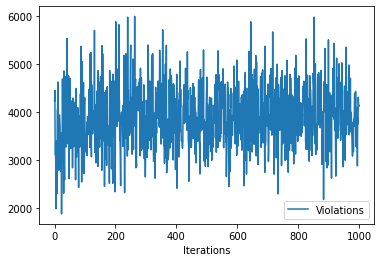

In [163]:
evalHardDF = pd.DataFrame(evaluationHardMap, columns=['Iterations', 'Violations'])
evalHardDF.plot.line(x='Iterations', y='Violations')

<AxesSubplot:xlabel='Iterations'>

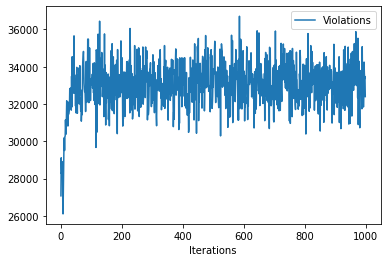

In [164]:
evalSoftDF = pd.DataFrame(evaluationSoftMap, columns=['Iterations', 'Violations'])
evalSoftDF.plot.line(x='Iterations', y='Violations')

In [165]:
examArr = []
for i in examObjects:
    if i.roomAssigned != False:
        examArr.append([i.code, i.slot, i.roomAssigned, i.room.code, i.duration, i.priority, i.conflicts, len(i.students), i.room.capacity, i.room.status])

In [166]:
pd.DataFrame(examArr).to_csv('exam_output.csv')

In [167]:
studentArr = []
for i in studentObjects:
    for j in i.exams:
        if j.roomAssigned != False:
            studentArr.append([i.code, j.code, j.slot, j.roomAssigned, j.room.code, j.duration, j.priority, j.conflicts, len(j.students), j.room.capacity, j.room.status])

In [168]:
pd.DataFrame(studentArr).to_csv('student_output.csv')